# Elastic Pendulum

Simulation of an elastic pendulum combining spring and pendulum dynamics.

You can also find this example as a standalone Python file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_elastic_pendulum.py).

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import ODE, Function, Scope
from pathsim.solvers import RKBS32

In [24]:
# Initial conditions
r0, vr0 = 2, 0.0
phi0, omega0 = 0.3*np.pi, 0.0

# Physical parameters
g = 9.81          # gravity [m/s^2]
l0 = 1.0          # natural spring length [m]
k = 50.0          # spring constant [N/m]
m = 1.0           # mass [kg]
c_r = 0.3         # radial damping [kg/s]
c_phi = 0.1       # angular damping [N m s]

$$
\dot{r} = v_r \\
$$

$$
\dot{v_r} = -\frac{k}{m} (r - l_0) - \frac{c_r}{m} v_r + \omega^2 r + g \cos(\varphi)
$$

In [63]:
# Define the radial ODE (spring-mass-damper with coupling terms)
def rad_ode(x, u, t):
    r, vr = x
    omega, phi = u
        
    # radial acceleration terms
    centrifugal = r * omega**2
    spring = -(k/m) * (r - l0)
    gravity_rad = g * np.cos(phi)
    damping = -(c_r/m) * vr
    
    accel_r = centrifugal + spring + gravity_rad + damping
    
    return np.array([vr, accel_r])

rad = ODE(rad_ode, np.array([r0, vr0]))

For the angular component we have the following odes:

$$
\dot{\varphi} = \omega
$$

$$
\dot{\omega} = - \frac{g}{r} \sin(\varphi) - \frac{2}{r} v_r \omega - \frac{c_\varphi}{r^2 m} \omega
$$

In [28]:
# Define the angular ODE (pendulum with coupling terms)
def ang_ode(x, u, t):
    phi, omega = x
    r, vr = u
    
    # angular acceleration terms
    gravity_torque = -(g / r) * np.sin(phi)
    coriolis = -(2 / r) * vr * omega
    damping = -(c_phi / (m * r**2)) * omega
    
    accel_phi = gravity_torque + coriolis + damping
    
    return np.array([omega, accel_phi])

ang = ODE(ang_ode, np.array([phi0, omega0]))

In [30]:
# Cartesian conversion
@Function
def crt(r, phi):
    return r*np.sin(phi), -r*np.cos(phi)

In [ ]:
# Scopes for visualization
sc1 = Scope(labels=["r [m]", "vr [m/s]", "phi [rad]", "omega [rad/s]"])
sc2 = Scope(labels=["x [m]", "y [m]"], sampling_period=0.005)

In [35]:
blocks = [rad, ang, crt, sc1, sc2]

In [37]:
connections = [
    Connection(ang[1], rad[0]),           # omega -> rad input 0
    Connection(ang[0], rad[1], crt[1]),   # phi -> rad input 1
    Connection(rad[0], ang[0], crt[0]),   # r -> ang input 0
    Connection(rad[1], ang[1]),           # vr -> ang input 1
    Connection(rad[:2], sc1[:2]),         # r, vr -> scope
    Connection(ang[:2], sc1[2:4]),        # phi, omega -> scope
    Connection(crt[:2], sc2[:2])
    ]

In [39]:
# Simulation instance
sim = Simulation(
    blocks,
    connections,
    Solver=RKBS32
    )

09:28:56 - INFO - LOGGING (log: True)
09:28:56 - INFO - BLOCKS (total: 5, dynamic: 2, static: 3, eventful: 1)
09:28:56 - INFO - GRAPH (nodes: 5, edges: 9, alg. depth: 2, loop depth: 0, runtime: 0.042ms)


In [41]:
# Run the simulation
sim.run(10)

09:28:57 - INFO - STARTING -> TRANSIENT (Duration: 10.00s)
09:28:57 - INFO - --------------------   1% | 0.0s<0.5s | 3747.2 it/s
09:28:57 - INFO - ####----------------  20% | 0.1s<0.2s | 6791.6 it/s
09:28:58 - INFO - ########------------  40% | 0.2s<0.2s | 6878.3 it/s
09:28:58 - INFO - ############--------  60% | 0.2s<0.1s | 7294.6 it/s
09:28:58 - INFO - ################----  80% | 0.3s<0.1s | 7393.4 it/s
09:28:58 - INFO - #################### 100% | 0.4s<--:-- | 7257.7 it/s
09:28:58 - INFO - FINISHED -> TRANSIENT (total steps: 2130, successful: 2083, runtime: 359.45 ms)


{'total_steps': 2130,
 'successful_steps': 2083,
 'runtime_ms': 359.44719999679364}

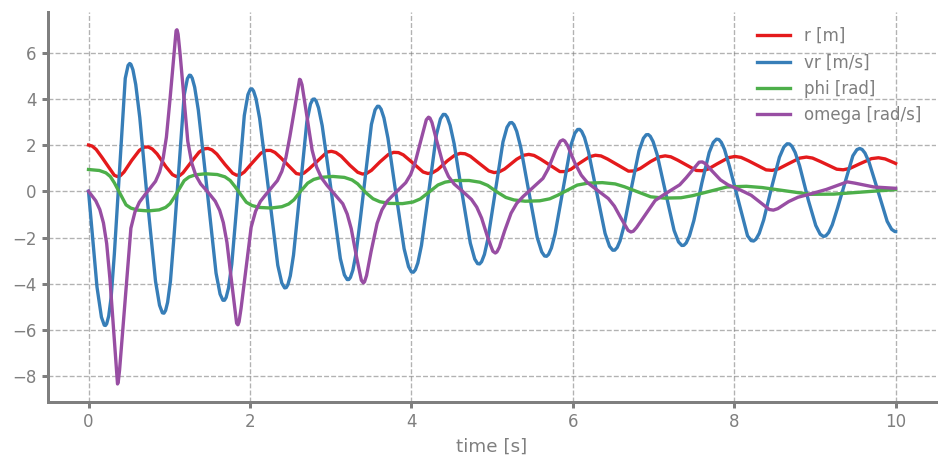

In [51]:
# Plot state variables
sc1.plot();

We can clearly see the mass jumping back and forth, driventhrough the contracting spring at each swing:

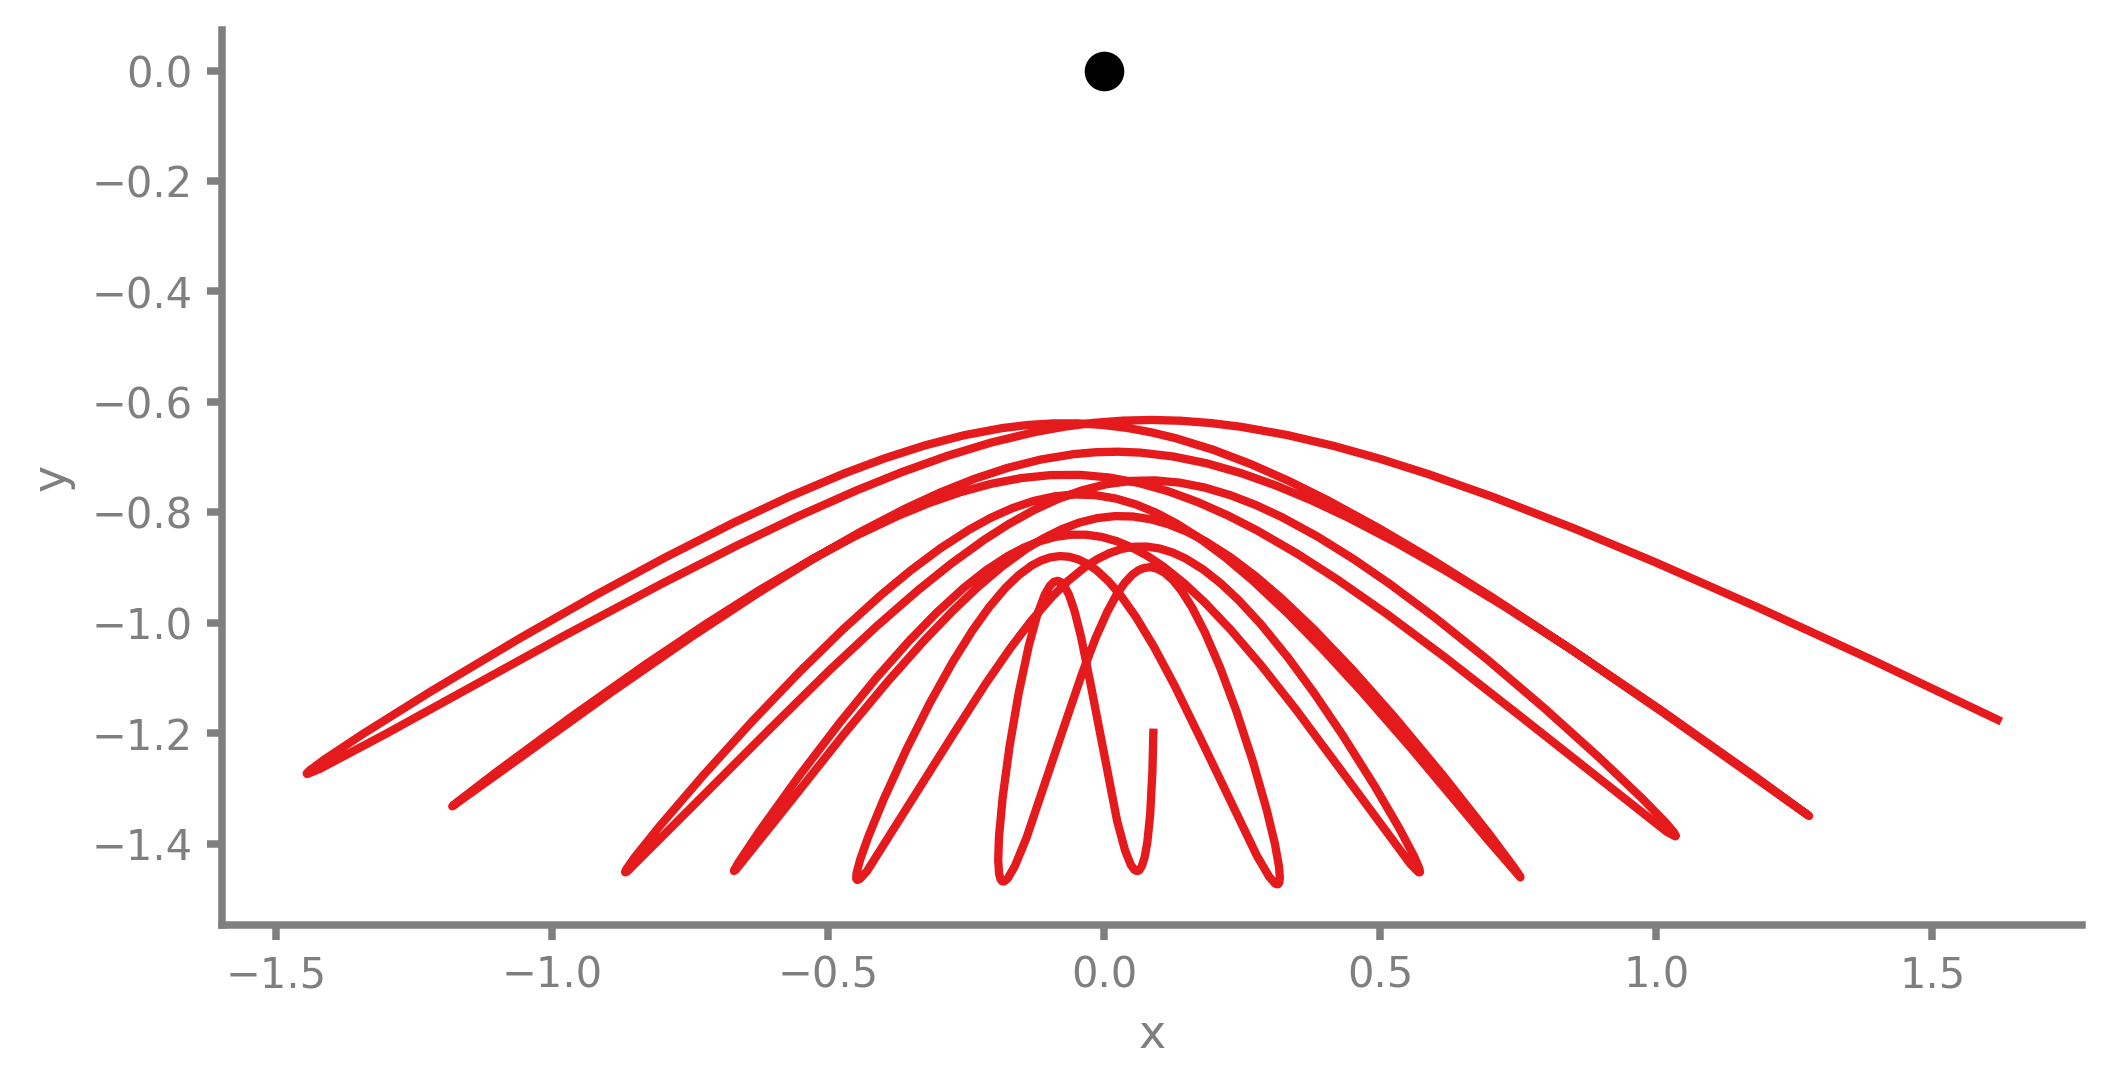

In [49]:
# Plot the trajectory

t, (x, y) = sc2.read()

fig, ax = plt.subplots()
ax.plot(0, 0, "o", c="k")
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)